In [1]:
import numpy as np
import constants as cnt
import matplotlib.pyplot as plt
import tools
import schottky_analysis as sch
from functools import lru_cache
from scipy.integrate import quad
from scipy.optimize import curve_fit


0.00014746639368170598 21.000000000000018
21.480000000000018


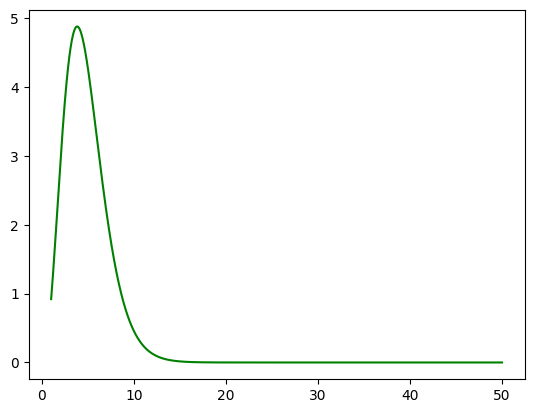

In [4]:
# test fonction intégrale

def fonction(x) :
    num = np.exp(x)*(x**4)
    denom = (np.exp(x) -1 )**2
    return num/denom

temp_test = np.arange(1, 50, 1e-2)

plt.figure()
plt.plot(temp_test, fonction(temp_test), "-g")

def zero(x, y, eps=1e-4) :
    i = 0
    for i in range(0, len(y)) :
        if y[i] < eps :
            return x[i]

print(fonction(temp_test)[2000], temp_test[2000])
print(zero(temp_test, fonction(temp_test)))

In [16]:
def integrand(t):
    # t scalar
    return t**4 * np.exp(t) / ((np.exp(t)-1)**2)

# Fonction pour I(y) avec mise en cache

@lru_cache(maxsize=1000)
def I_of_y_scalar(y):
   val, err = quad(integrand, 0, y)
   return val

def I(y_array) :
    result = []
    for yi in y_array :
        result.append(I_of_y_scalar(float(yi)))
    return result

y_test = np.arange(1, 400,1)

print(I(y_test))

[0.3172440452344265, 2.201088102433341, 5.964822397371477, 10.73193239299862, 15.35978431688218, 19.122976016053165, 21.821248922866914, 23.583979156921938, 24.65650393465895, 25.27366767703044, 25.61324225583976, 25.79334730171151, 25.885992976160253, 25.932431605893495, 25.955198214572256, 25.966147104202232, 25.97132485339212, 25.97373738268685, 25.9748467680487, 25.975350935212237, 25.975577640786717, 25.975678609099337, 25.975723187336634, 25.975742712990424, 25.975751203267095, 25.975754870391235, 25.975756444524418, 25.97575711636929, 25.975757401593484, 25.975757522084095, 25.9757575727497, 25.97575759396241, 25.97575760280786, 25.97575760648229, 25.975757608003207, 25.975757608630627, 25.97575760888862, 25.975757608994392, 25.975757609037636, 25.97575760905526, 25.975757609062438, 25.97575760906534, 25.975757609066523, 25.975757609067003, 25.975757609067198, 25.97575760906729, 25.97575760906734, 25.97575760906731, 25.975757609067315, 25.975757609067312, 25.975757609067315, 25.

/tmp/ipykernel_9217/1270378490.py:3: RuntimeWarning: overflow encountered in scalar power
  return t**4 * np.exp(t) / ((np.exp(t)-1)**2)


[25.97575760906731, 25.975757609067312, 25.975757609067315, 25.97575760906735, 25.97575760906735, 25.975757609067347, 25.975757609067315, 25.97575760906732, 25.975757609067312, 25.975757609067312, 25.97575760906732, 25.975757609067315, 25.975757609067315, 25.97575760906732, 25.975757609067315, 25.975757609067323, 25.975757609067312, 25.97575760906732, 25.975757609067315, 25.97575760906732, 25.975757609067315, 25.97575760906732, 25.975757609067315, 25.975757609067315, 25.975757609067315, 25.97575760906731, 25.975757609067315, 25.975757609067315, 25.975757609067315, 25.97575760906732, 25.97575760906734, 25.975757609067337, 25.975757609067337, 25.975757609067312, 25.97575760906732, 25.975757609067323, 25.97575760906732, 25.975757609067315, 25.975757609067315, 25.97575760906732, 25.97575760906732, 25.975757609067315, 25.97575760906732, 25.97575760906732, 25.975757609067323, 25.975757609067323, 25.975757609067315, 25.975757609067315, 25.975757609067315, 25.975757609067323, 25.97575760906732

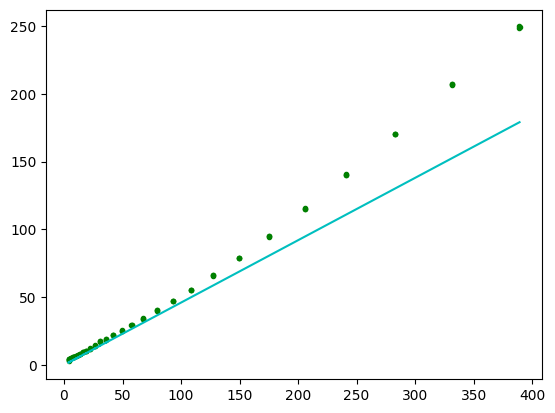

In [ ]:
def integrand(t):
    # t scalar
    return t**4 * np.exp(t) / ((np.exp(t)-1)**2)

# Fonction pour I(y) avec mise en cache

@lru_cache(maxsize=1000)
def I_of_y_scalar(y):
   val, err = quad(integrand, 0, y)
   return val

def I(y_array) :
    result = []
    for yi in y_array :
        result.append(I_of_y_scalar(float(yi)))
    return result

def model(x, theta, gamma):
    """
    Modèle f(x) = gamma + x * I(theta / x)
    x: array-like positif
    theta, gamma: scalaires
    """
    x_arr = np.asarray(x, dtype=float)
    y_arr = theta / np.sqrt(x_arr)
    I_vals = I(y_arr)
    print(I_vals)
    return gamma + x_arr * I_vals* 9*cnt.k*cnt.N/(theta**3)

temperature_bounded, err_bounded = tools.tab_interval(cnt.temperature, cnt.err_C_divT, 0, 20)
squared_temperature_bounded, C_div_T_bounded = tools.tab_interval(cnt.squared_temperature, cnt.C_div_T, 0, 400)
y_data = C_div_T_bounded - sch.schottky(temperature_bounded, cnt.E_optic, cnt.n_optic)/temperature_bounded

print(model(squared_temperature_bounded, 400, 0))

plt.figure()
plt.plot(squared_temperature_bounded, y_data, ".g")
plt.plot(squared_temperature_bounded, model(squared_temperature_bounded, 400, 0), "-c")
#plt.plot(y_test, I(y_test))

In [ ]:
@lru_cache(maxsize=1000)
def I_of_y_scalar(y):
    # y est un scalaire Python float >= 0
    val, err = quad(lambda t: integrand(t), 0, y, epsabs=1e-8, epsrel=1e-8)
    return val

y_arr = np.atleast_1d(y_array)
    result = np.empty_like(y_arr, dtype=float)
    for i, yi in enumerate(y_arr):
        if yi < 0:
            raise ValueError(f"y must be >=0, got {yi}")
        result[i] = I_of_y_scalar(float(yi))
    if np.isscalar(y_array):
        return result.item()
    return result